In [1]:
import pickle
import numpy as np
from tqdm import tqdm
from skimage.color import gray2rgb
from NOMADS_postproc import postproc
from matplotlib import pyplot as plt
from Quality import make_overlap_img

# Import Algorithm and Data Handler (from rapidalg)

In [3]:
from NOMADS_beta import NomadsBeta
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""
from data_handler import load_and_preproc, get_train_set

## Load And Preprocess Data
- Z-Transform within slice

In [4]:
data = load_and_preproc('./data/rorb_data.data', True)
biomarker_list = ['PSD95', 'synapsin', 'Gephyrin', 'VGlut1', 'GABA', 'GAD2', 'GluN1']
train_data = {}
test_data = {}
for key in biomarker_list + ['annotation']:
    vol = data[key]
    train_data[key] = vol[vol.shape[0]//2:, :, :]
    test_data[key] = vol[:vol.shape[0]//2, :, :]

## Make Train Set
- Method get_train_set included in Data Handler
    - Any Shape Volume
    - Any Num Channels
    - Any Class Balance Ratio

In [5]:
train_features, train_labels = get_train_set(train_data, 8, 1, biomarker_list, balance=True, positive_to_negative_ratio=1/1.5)
test_features, test_labels = get_train_set(test_data, 8, 1, biomarker_list, balance=True, positive_to_negative_ratio=1/1.5)

## Make NomadsBeta Model & Run Training

In [5]:
model = NomadsBeta(len(biomarker_list),
                   learning_rate = 1e-4,
                   decay=0.005)

In [ ]:

batch_size = 512 
epochs = 5
losses = []
f1s = []

for epoch in range(epochs):
    #50 Iterations for sake of Demo
    for iteration, batch_start_idx in enumerate(range(0, len(train_features), batch_size)):
        batch_features = np.stack(train_features[batch_start_idx:batch_start_idx+batch_size])
        batch_labels = np.stack(train_labels[batch_start_idx:batch_start_idx+batch_size])
        if not iteration % 2:
            batch_pretrain_pred = model.predict_on_batch(batch_features)
            tp = 0
            fp = 0
            fn = 0
            for i in range(len(batch_labels)):
                if np.argmax(batch_pretrain_pred[i]) == np.argmax(batch_labels[i]):
                    if np.argmax(batch_labels[i]):
                        tp +=1
                else:
                    if np.argmax(batch_labels[i]):
                        fn +=1
                    else:
                        fp +=1

            prec = tp/(tp+fp+1)
            rec = tp/(tp+fn+1)
            f1 = 2*prec*rec/(prec+rec+1)
            f1s.append(f1)
        print("got here")
        cur_loss = model.train_on_batch(batch_features, batch_labels)
        losses.append(cur_loss)
    print("got here")

got here
got here


In [6]:

loaded_model = NomadsBeta(len(biomarker_list),
                          learning_rate = 1e-4,
                          decay=.0005,
                          checkpoint='./data/model.h5')

#loaded_model = model

# Evaluate on Test Set

In [7]:
test_set_predictions = loaded_model.predict_on_batch(np.stack(test_features))

In [8]:
tp = 0
fp = 0
fn = 0
for i in range(len(test_set_predictions)):
    if np.argmax(test_set_predictions[i]) == np.argmax(test_labels[i]):
        if np.argmax(test_labels[i]):
            tp +=1
    else:
        if np.argmax(test_labels[i]):
            fn +=1
        else:
            fp +=1

In [9]:
prec = tp/(tp+fp)
rec = tp/(tp+fn)
print('Prec: ', prec)
print('Rec: ', rec)
print('F1: ', 2*prec*rec/(prec+rec))

Prec:  0.7094329028635598
Rec:  0.6530559503811862
F1:  0.6800780461548813


# Collman Plot

In [10]:
full_data = np.stack([test_data[biomarker] for biomarker in biomarker_list])
full_data = np.moveaxis(full_data, 0, -1)
print(full_data.shape)

(19, 136, 143, 7)


In [11]:
radius = 8
full_gt = test_data['annotation']
full_gt = full_gt[1:-2, radius:-radius-1, radius:-radius-1]

In [12]:
full_predictions = np.zeros(full_data.shape[:-1])
for z in tqdm(range(1, full_data.shape[0]-2)):
    for y in range(radius, full_data.shape[1]-radius-1):
        for x in range(radius, full_data.shape[2]-radius-1):
            window = full_data[z-1:z+2, y-radius:y+radius, x-radius:x+radius, :]
            prediction = np.squeeze(loaded_model.predict_on_batch(np.stack([window])))
            if np.argmax(prediction):
                full_predictions[z, y, x] = 1

100%|██████████| 16/16 [08:07<00:00, 30.49s/it]


In [13]:
full_predictions = full_predictions[1: -2, radius:-radius-1, radius:-radius-1]
full_predictions.shape

(16, 119, 126)

In [71]:
full_postproc = np.stack([postproc(elem, 10) for elem in full_predictions])

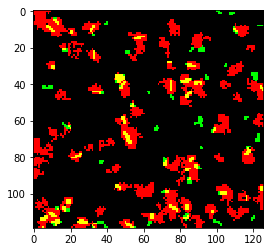

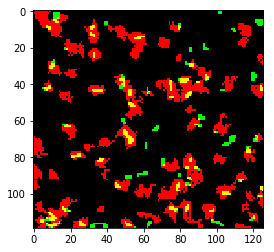

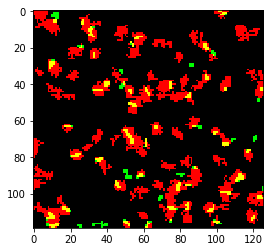

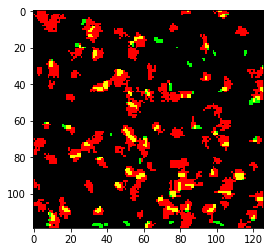

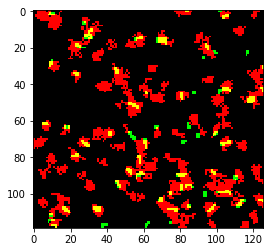

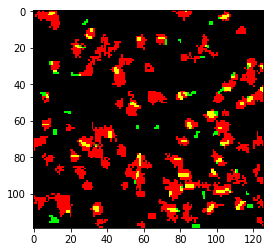

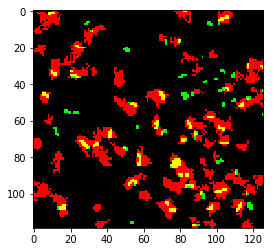

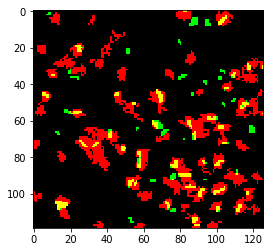

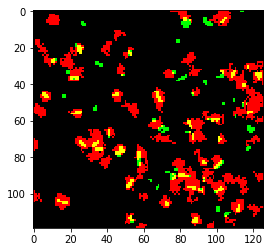

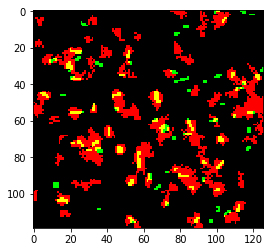

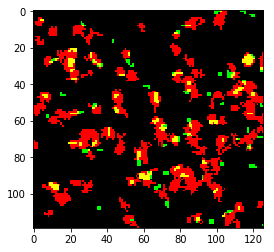

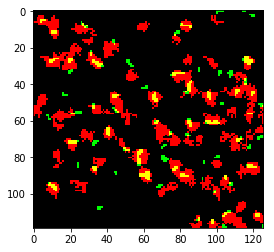

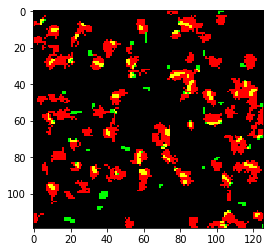

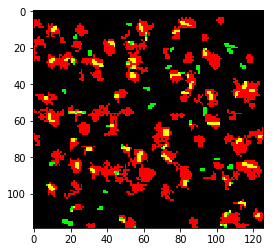

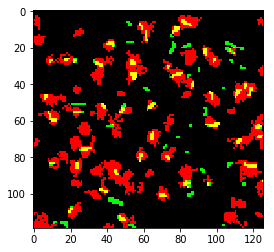

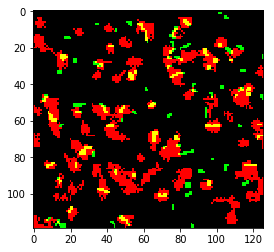

In [15]:
for idx, z_postproc in enumerate(full_postproc):
    plt.figure()
    img = make_overlap_img(z_postproc, full_gt[idx])
    plt.imshow(img)
    plt.show()

In [16]:
from skimage.measure import label
def get_b_per_a(a=None, b=None, disp=False):
    l_a = label(a > 0)
    l_b = label(b > 0)
    counts = []
    for a_idx in np.unique(l_a):
        #dont count background
        if a_idx != 0:
            rel_locs = [elem for elem in zip(*(np.where(l_a == a_idx)))]
            uniques = np.unique([l_b[elem] for elem in rel_locs])
            if disp:
                print(a_idx, '\t', uniques)
            count = len(uniques)
            
            if 0 in uniques:
                count -=1
            counts.append(count)
    return counts

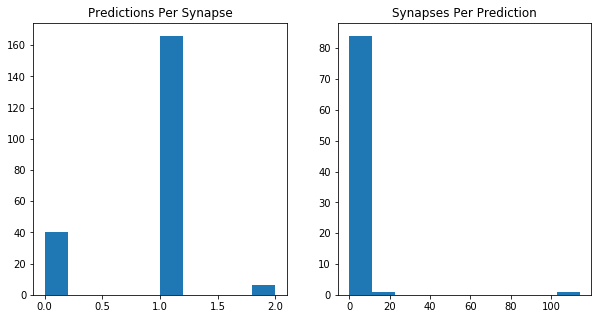

In [17]:
plt.figure(figsize=(10, 5))
ax = plt.subplot(121)
ax.set_title('Predictions Per Synapse')
dist = []
dist = get_b_per_a(a=full_gt[1:-2] > 0, b=full_postproc[1:-2] > 0)
plt.hist(dist)
ax = plt.subplot(122)
ax.set_title('Synapses Per Prediction')
dist = get_b_per_a(b=full_gt[1:-2] > 0, a=full_postproc[1:-2] > 0)
plt.hist(dist)
plt.show()

In [18]:
print(test_set_predictions)

[[0.37268317 0.62731683]
 [0.6934263  0.30657378]
 [0.6321196  0.36788043]
 ...
 [0.2941834  0.7058166 ]
 [0.3349634  0.6650366 ]
 [0.27001783 0.72998214]]


In [19]:
print(test_set_predictions.shape)

(19347, 2)


In [20]:
print(test_labels)

[[False, True], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [False, True], [True, False], [True, False], [False, True], [True, False], [True, False], [True, False], [False, True], [True, False], [False, True], [False, True], [False, True], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [False, True], [True, False], [True, False], [False, True], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [False, True], [False, True], [False, True], [True, False], [False, True], [True, False], [False, True], [False, True], [True, False], [True, False], [True, False], [True, False], [False, True], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [False, True], [True, False], [True, False], [False, True], [True, False], [False, True], [False, True], [True, False], [True, Fa

In [21]:
print(full_postproc)

[[[ True  True  True ... False False False]
  [ True  True  True ... False False False]
  [ True  True  True ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False  True  True ... False False False]
  [ True  True  True ... False False False]
  [False  True  True ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[ True  True  True ... False False False]
  [ True  True  True ... False False False]
  [ True  True  True ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 ...

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False Fal

In [22]:
from skimage import measure
from skimage import filters

In [23]:
import numpy as np

In [77]:
synapse_labels = measure.label(full_postproc, background=0)

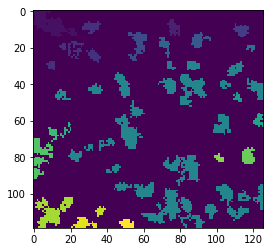

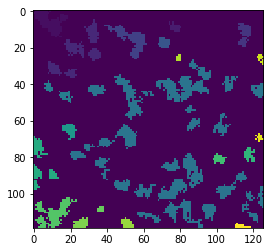

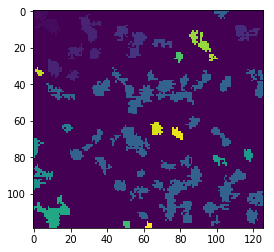

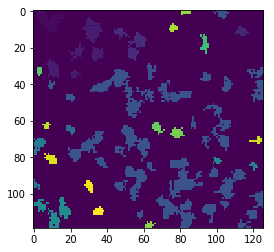

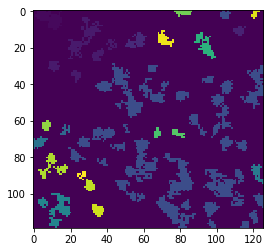

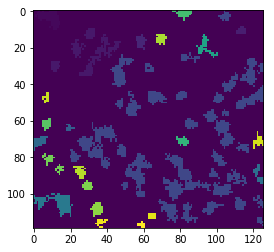

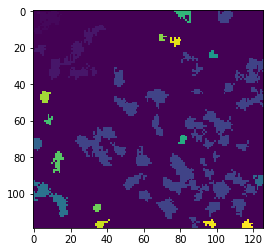

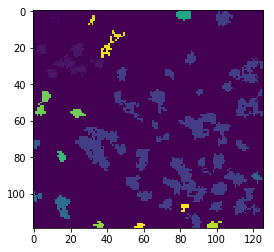

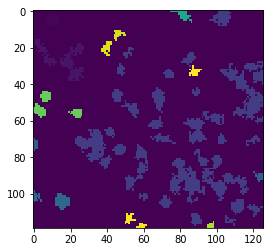

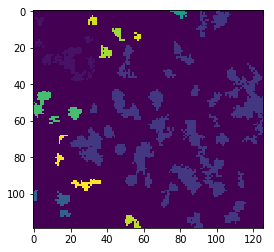

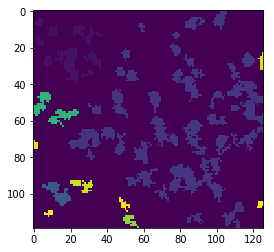

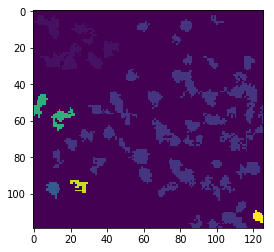

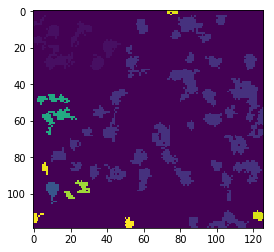

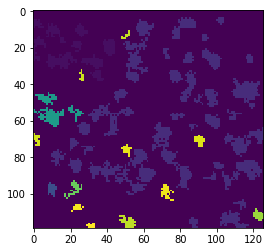

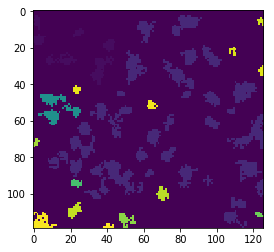

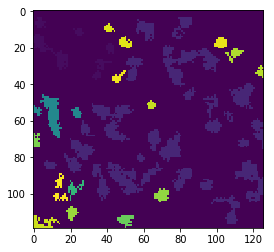

In [78]:
for i in range(synapse_labels.shape[0]):
    plt.figure()
    plt.imshow(synapse_labels[i])
    plt.show()

In [79]:
print(np.unique(synapse_labels[15]))
print(np.unique(synapse_labels[0]))

[ 0  3 10 43 61 71 74 77 78 81 82 84 85 87 88 89 90 91 92]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


In [80]:
test = synapse_labels[0]
print(test[0][0])
print(np.unique(test))

1
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


In [82]:
connected_components = {}
for y in range(test.shape[0]):
    for x in range(test.shape[1]):
        if (test[y][x] in connected_components.keys()):
            connected_components[test[y][x]].append((y, x))
        else:
            connected_components[test[y][x]] = [(y, x)]

print(connected_components.keys())
connected_components.pop(0)

dict_keys([1, 0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])


[(0, 10),
 (0, 11),
 (0, 12),
 (0, 13),
 (0, 14),
 (0, 15),
 (0, 16),
 (0, 17),
 (0, 18),
 (0, 19),
 (0, 20),
 (0, 21),
 (0, 22),
 (0, 23),
 (0, 24),
 (0, 25),
 (0, 26),
 (0, 27),
 (0, 28),
 (0, 29),
 (0, 30),
 (0, 31),
 (0, 32),
 (0, 33),
 (0, 34),
 (0, 35),
 (0, 36),
 (0, 37),
 (0, 38),
 (0, 39),
 (0, 40),
 (0, 41),
 (0, 42),
 (0, 43),
 (0, 44),
 (0, 45),
 (0, 46),
 (0, 47),
 (0, 48),
 (0, 49),
 (0, 50),
 (0, 51),
 (0, 52),
 (0, 53),
 (0, 54),
 (0, 55),
 (0, 56),
 (0, 57),
 (0, 58),
 (0, 59),
 (0, 60),
 (0, 61),
 (0, 62),
 (0, 63),
 (0, 64),
 (0, 65),
 (0, 66),
 (0, 67),
 (0, 68),
 (0, 69),
 (0, 70),
 (0, 71),
 (0, 72),
 (0, 73),
 (0, 74),
 (0, 75),
 (0, 76),
 (0, 77),
 (0, 78),
 (0, 79),
 (0, 80),
 (0, 81),
 (0, 82),
 (0, 83),
 (0, 84),
 (0, 85),
 (0, 86),
 (0, 87),
 (0, 88),
 (0, 89),
 (0, 90),
 (0, 91),
 (0, 92),
 (0, 93),
 (0, 94),
 (0, 95),
 (0, 96),
 (0, 97),
 (0, 98),
 (0, 99),
 (0, 100),
 (0, 101),
 (0, 102),
 (0, 103),
 (0, 104),
 (0, 105),
 (0, 106),
 (0, 107),
 (0, 108),
 

In [88]:
synapse_centroids = []
for key, value in connected_components.items():
    y, x = zip(*value)
    synapse_centroids.append((int(sum(y)/len(y)), int(sum(x)/len(x))))

In [89]:
print(synapse_centroids)

[(7, 9), (9, 76), (18, 25), (10, 113), (18, 56), (16, 90), (18, 71), (20, 118), (29, 74), (75, 78), (45, 15), (47, 111), (59, 122), (65, 17), (66, 10), (79, 3), (79, 116), (80, 101), (109, 10), (109, 36), (115, 27), (116, 50)]


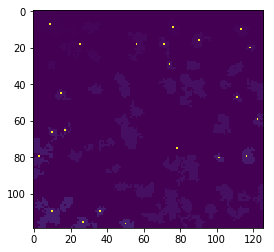

In [92]:
for elem in synapse_centroids:
    test[elem] = 255
    
plt.figure()
plt.imshow(test)
plt.show()

In [94]:
connected_components = {}
for z in range(synapse_labels.shape[0]):
    for y in range(synapse_labels.shape[1]):
        for x in range(synapse_labels.shape[2]):
            if (synapse_labels[z][y][x] in connected_components.keys()):
                connected_components[synapse_labels[z][y][x]].append((z, y, x))
            else:
                connected_components[synapse_labels[z][y][x]] = [(z, y, x)]

connected_components.pop(0)

[(0, 0, 10),
 (0, 0, 11),
 (0, 0, 12),
 (0, 0, 13),
 (0, 0, 14),
 (0, 0, 15),
 (0, 0, 16),
 (0, 0, 17),
 (0, 0, 18),
 (0, 0, 19),
 (0, 0, 20),
 (0, 0, 21),
 (0, 0, 22),
 (0, 0, 23),
 (0, 0, 24),
 (0, 0, 25),
 (0, 0, 26),
 (0, 0, 27),
 (0, 0, 28),
 (0, 0, 29),
 (0, 0, 30),
 (0, 0, 31),
 (0, 0, 32),
 (0, 0, 33),
 (0, 0, 34),
 (0, 0, 35),
 (0, 0, 36),
 (0, 0, 37),
 (0, 0, 38),
 (0, 0, 39),
 (0, 0, 40),
 (0, 0, 41),
 (0, 0, 42),
 (0, 0, 43),
 (0, 0, 44),
 (0, 0, 45),
 (0, 0, 46),
 (0, 0, 47),
 (0, 0, 48),
 (0, 0, 49),
 (0, 0, 50),
 (0, 0, 51),
 (0, 0, 52),
 (0, 0, 53),
 (0, 0, 54),
 (0, 0, 55),
 (0, 0, 56),
 (0, 0, 57),
 (0, 0, 58),
 (0, 0, 59),
 (0, 0, 60),
 (0, 0, 61),
 (0, 0, 62),
 (0, 0, 63),
 (0, 0, 64),
 (0, 0, 65),
 (0, 0, 66),
 (0, 0, 67),
 (0, 0, 68),
 (0, 0, 69),
 (0, 0, 70),
 (0, 0, 71),
 (0, 0, 72),
 (0, 0, 73),
 (0, 0, 74),
 (0, 0, 75),
 (0, 0, 76),
 (0, 0, 77),
 (0, 0, 78),
 (0, 0, 79),
 (0, 0, 80),
 (0, 0, 81),
 (0, 0, 82),
 (0, 0, 83),
 (0, 0, 84),
 (0, 0, 85),
 (0, 0, 86),

In [97]:
synapse_centroids = []
for key, value in connected_components.items():
    z, y, x = zip(*value)
    synapse_centroids.append((int(sum(z)/len(z)), int(sum(y)/len(y)), int(sum(x)/len(x))))
for elem in synapse_centroids:
    synapse_labels[elem] = 200

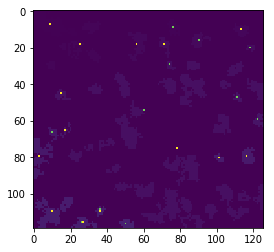

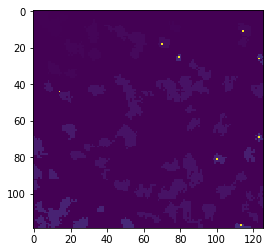

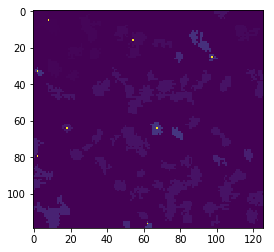

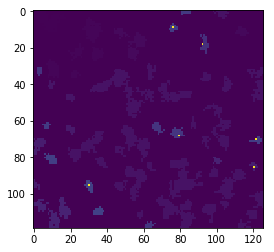

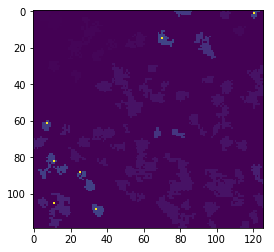

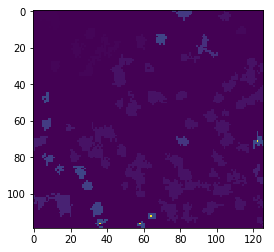

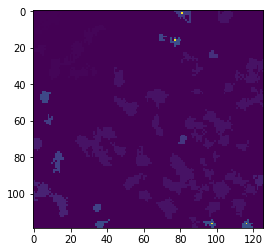

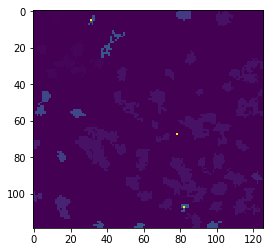

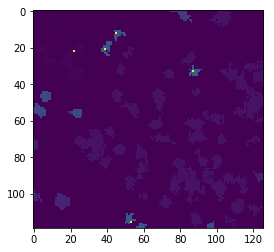

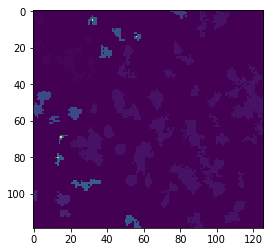

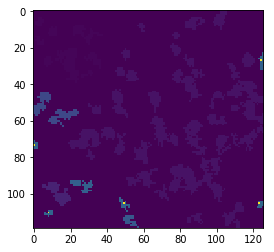

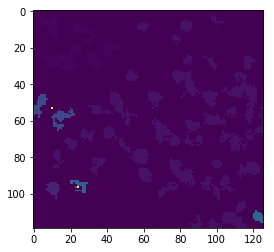

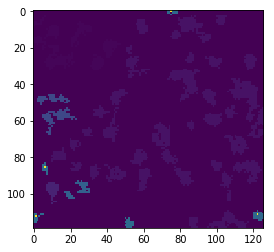

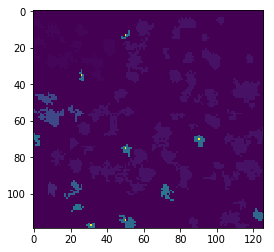

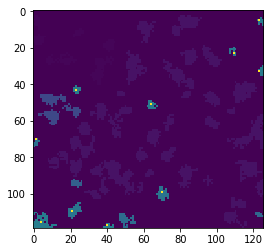

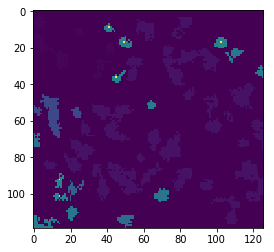

In [98]:
for i in range(synapse_labels.shape[0]):
    plt.figure()
    plt.imshow(synapse_labels[i])
    plt.show()

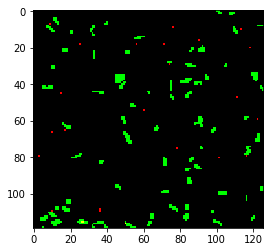

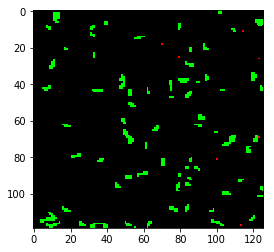

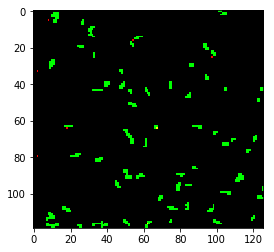

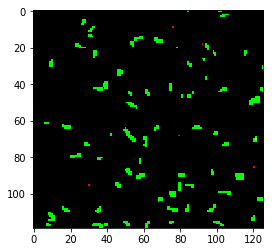

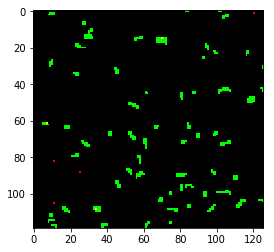

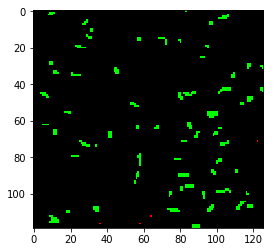

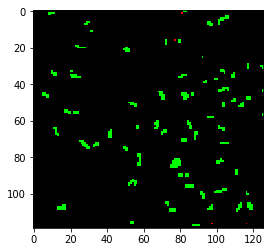

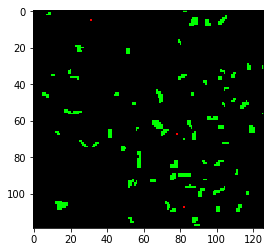

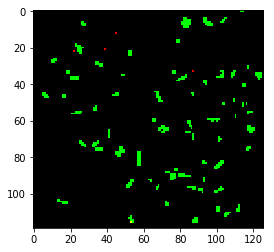

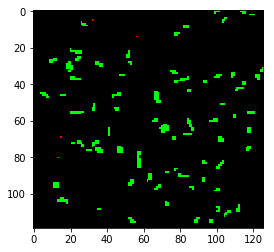

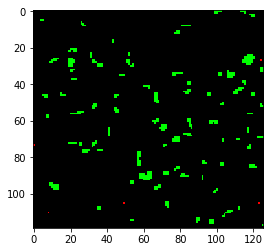

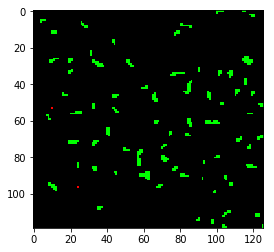

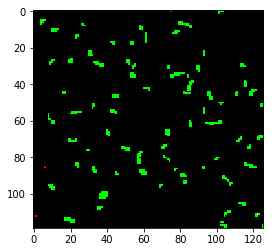

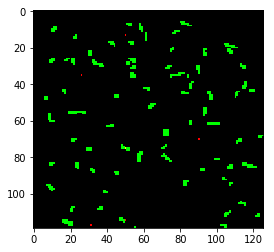

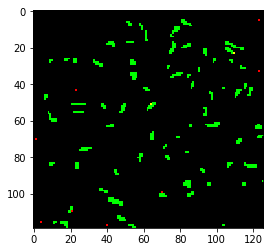

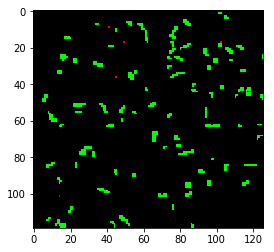

In [104]:
test = synapse_labels
test[np.where( test < 200 )] = 0
for idx, z_postproc in enumerate(full_postproc):
    plt.figure()
    img = make_overlap_img(test[idx], full_gt[idx])
    plt.imshow(img)
    plt.show()